In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df_val = pd.read_csv("test.csv")

In [4]:
df.describe()

,sample,x1,x2,x3,x4,d
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,18.000000,0.451929,-0.131920,0.476843,1.808543,-0.028571
std,10.246951,0.499282,1.176683,0.320427,1.950920,1.014185
min,1.000000,-0.523100,-3.232900,-0.229100,-2.457200,-1.000000
25%,9.500000,0.141450,-0.977050,0.276900,0.796100,-1.000000
50%,18.000000,0.435300,-0.048500,0.477800,1.577600,-1.000000
75%,26.500000,0.729000,0.654800,0.720800,3.054700,1.000000
max,35.000000,1.427600,2.147900,1.053000,5.823500,1.000000


In [5]:
df_val.describe()

,sample,x1,x2,x3,x4
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,8.000000,0.533780,0.547973,0.644513,2.486840
std,4.472136,0.489624,1.400279,0.252950,1.713328
min,1.000000,-0.187400,-2.065600,0.203000,-0.658500
25%,4.500000,0.282350,-0.467150,0.487600,1.115250
50%,8.000000,0.506000,0.690900,0.612400,3.218900
75%,11.500000,0.770300,1.333000,0.837950,3.606950
max,15.000000,1.637500,3.536900,1.035900,5.353200


In [6]:
# Semilla para reproducibilidad
rng = np.random.default_rng(7)

X = df[["x1","x2","x3","x4"]].to_numpy(dtype=float)
y = df["d"].to_numpy(dtype=float)
N, d = X.shape

rng = np.random.default_rng(7)
idx = rng.permutation(len(X))
n_tr = int(0.8*len(X))
tr, va = idx[:n_tr], idx[n_tr:]
X_tr, y_tr = X[tr], y[tr]
X_va, y_va = X[va], y[va]

#Estandarización (z-score) con stats de TRAIN
mu = X_tr.mean(axis=0)
sigma = X_tr.std(axis=0, ddof=0)
sigma[sigma == 0] = 1.0  # evita división por cero

X_tr_std = (X_tr - mu)/sigma
X_va_std = (X_va - mu)/sigma
X2_std = (df_val[["x1","x2","x3","x4"]].to_numpy(float) - mu)/sigma
print("X_std shape:", X_tr_std.shape, "y shape:", y.shape)
print("medias:", mu, "desv.std:", sigma)

X_std shape: (28, 4) y shape: (35,)
medias: [ 0.43183571 -0.07778214  0.48823571  1.85646429] desv.std: [0.5068441  1.19491107 0.32223124 1.99244552]


In [7]:
#algoritmo de prueba 1
class AdalineGD:
    def __init__(self, eta=0.01, n_epochs=50, random_state=7):
        self.eta = eta
        self.n_epochs = n_epochs
        self.rng = np.random.default_rng(random_state)
        # Se inicializan al entrenar: self.w (d,), self.w0 (esc), self.J_history (list)

    def net_input(self, X):
        # z = X @ w + w0
        return X @ self.w + self.w0

    def fit(self, X, y):
        N, d = X.shape
        # inicialización pequeña
        self.w = self.rng.uniform(0.0, 1.0, size=d) # 1 se inicializan los pesos w aleatorio entre 0 y 1
        self.w0 = 0.0 # el bias 
        self.J_history = []

        for _ in range(self.n_epochs):#se realiza el proceso de entrenamiento de acuerdo a las epocas y demas parametros 
            z = self.net_input(X)            # (N,)
            y_hat = z                        # salida lineal
            errors = y - y_hat               # (N,)

            # Gradientes de J = 1/2 sum (y - y_hat)^2
            # dJ/dw = - X^T @ errors
            # dJ/dw0 = - sum(errors)
            grad_w  = -(X.T @ errors)
            grad_w0 = -errors.sum()

            # Actualización
            self.w  -= self.eta * grad_w
            self.w0 -= self.eta * grad_w0

            # Coste MSE/2 por época (opcional: promedio)
            J = 0.5 * np.mean(errors**2)
            self.J_history.append(J)
        return self

    def predict_continuous(self, X):
        return self.net_input(X)

    def predict_class(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# ---- Entrenamiento en X_std, y (del paso previo) ----
adaline = AdalineGD(eta=0.0025, n_epochs=50, random_state=7).fit(X_tr_std, y_tr)

print("w:", adaline.w)
print("w0:", adaline.w0)
print("J[0], J[-1]:", adaline.J_history[0], adaline.J_history[-1])

y_pred = adaline.predict_class(X_tr_std)
acc = (y_pred == y_tr).mean()
print("accuracy:", acc)

w: [ 0.31499916  0.60400707  0.06875492 -0.74581348]
w0: -2.7755575615629092e-18
J[0], J[-1]: 1.2780484507394607 0.3083114292524441
accuracy: 0.9285714285714286


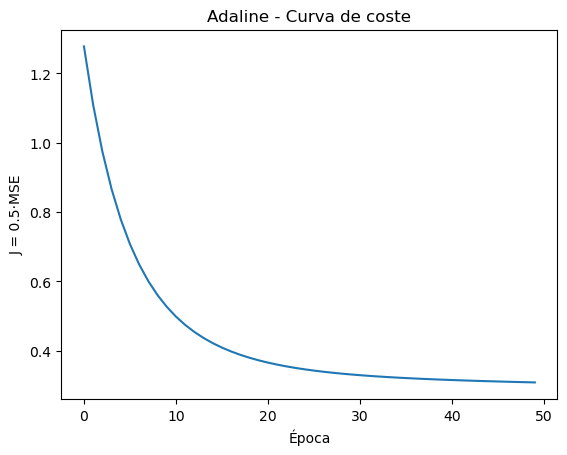

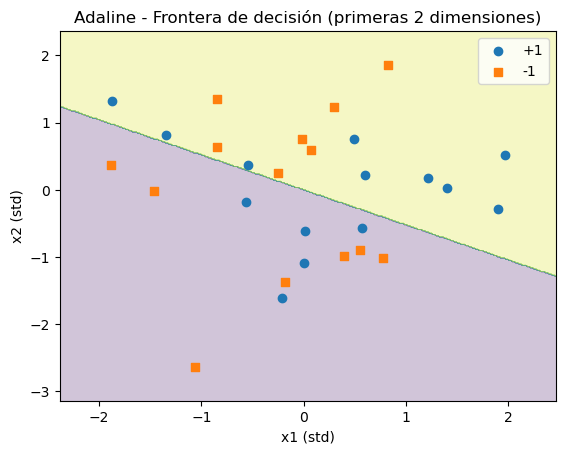

In [8]:
# --- curva de coste ---
plt.figure()
plt.plot(adaline.J_history)
plt.xlabel("Época")
plt.ylabel("J = 0.5·MSE")
plt.title("Adaline - Curva de coste")
plt.show()

# --- frontera de decisión en 2D ---
def plot_decision_boundary(model, X, y):
    # Usar solo las dos primeras dimensiones
    X_2d = X[:, :2]  # Seleccionar solo x1 y x2
    
    x1_min, x1_max = X_2d[:,0].min()-0.5, X_2d[:,0].max()+0.5
    x2_min, x2_max = X_2d[:,1].min()-0.5, X_2d[:,1].max()+0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                          np.linspace(x2_min, x2_max, 300))
    
    # Crear grid 2D y rellenar con ceros las otras dimensiones
    grid = np.zeros((xx1.ravel().shape[0], X.shape[1]))
    grid[:, 0] = xx1.ravel()
    grid[:, 1] = xx2.ravel()
    
    Z = model.predict_class(grid).reshape(xx1.shape)

    plt.figure()
    plt.contourf(xx1, xx2, Z, alpha=0.25)
    plt.scatter(X_2d[y==1,0], X_2d[y==1,1], marker='o', label='+1')
    plt.scatter(X_2d[y==-1,0], X_2d[y==-1,1], marker='s', label='-1')
    
    plt.legend()
    plt.title("Adaline - Frontera de decisión (primeras 2 dimensiones)")
    plt.xlabel("x1 (std)")
    plt.ylabel("x2 (std)")
    plt.show()

plot_decision_boundary(adaline, X_tr_std, y_tr)

In [9]:
class AdalineGDTrack:
    def __init__(self, eta=0.01, n_epochs=10, random_state=7):
        self.eta = eta
        self.n_epochs = n_epochs
        self.rng = np.random.default_rng(random_state)

    def net_input(self, X):
        return X @ self.w + self.b

    def fit(self, X, y):
        N, d = X.shape
        self.w = self.rng.uniform(0.0, 1.0, size=d)# 1 se inicializan los pesos w aleatorio entre 0 y 1
        self.b = 0.0
        self.J_history = []      # 0.5 * MSE por época
        self.mse_history = []    # MSE por época
        logs = []
        for epoch in range(1, self.n_epochs+1):#se realiza el proceso de entrenamiento de acuerdo a las epocas y demas parametros 
            z = self.net_input(X)
            err = y - z
            grad_w  = -(X.T @ err) / N
            grad_b  = -err.mean()

            # guardar estado inicial de la época
            w_init = self.w.copy()
            b_init = self.b

            # actualización
            self.w -= self.eta * grad_w
            self.b -= self.eta * grad_b

            # estado final
            w_final = self.w.copy()
            b_final = self.b

            J = 0.5 * np.mean(err**2)

            mse = np.mean(err**2)     # dentro del fit(), por época
            self.mse_history.append(mse)            
            self.J_history.append(J)
            # fila para el dataframe (init + final en la misma fila)
            row = {"epoch": epoch, "J": J, "b_init": b_init, "b_final": b_final}
            for j in range(d):
                row[f"w{j}_init"]  = w_init[j]
                row[f"w{j}_final"] = w_final[j]
                # opcional: deltas
                row[f"dw{j}"] = w_final[j] - w_init[j]
            row["db"] = b_final - b_init
            logs.append(row)

        self.history_df = pd.DataFrame(logs)
        return self

    def predict_class(self, X):
        return np.where(self.net_input(X) >= 0, 1, -1)

In [10]:
# Ejemplo de uso (asumiendo X_std, y creados antes):
adal = AdalineGDTrack(eta=0.0025, n_epochs=800).fit(X_tr_std, y_tr)# el numero de iteraciones (epocas) afecta terriblemente el error cuadratico medio, explicar 
df = adal.history_df
df.head()# los d corresponde a los deltas obtenidos del gradiente 

,epoch,J,b_init,b_final,w0_init,w0_final,dw0,w1_init,w1_final,dw1,w2_init,w2_final,dw2,w3_init,w3_final,dw3,db
0,1,1.278048,0.000000e+00,1.784287e-19,0.625095,0.624315,-0.000781,0.897214,0.895024,-0.002190,0.775686,0.774408,-0.001278,0.225207,0.222231,-0.002976,1.784287e-19
1,2,1.271701,1.784287e-19,5.055480e-19,0.624315,0.623536,-0.000779,0.895024,0.892844,-0.002179,0.774408,0.773130,-0.001277,0.222231,0.219266,-0.002965,3.271193e-19
2,3,1.265402,5.055480e-19,6.740640e-19,0.623536,0.622759,-0.000777,0.892844,0.890676,-0.002168,0.773130,0.771853,-0.001277,0.219266,0.216313,-0.002953,1.685160e-19
3,4,1.259151,6.740640e-19,8.524927e-19,0.622759,0.621984,-0.000775,0.890676,0.888518,-0.002158,0.771853,0.770577,-0.001276,0.216313,0.213371,-0.002942,1.784287e-19
4,5,1.252948,8.524927e-19,1.130048e-18,0.621984,0.621210,-0.000773,0.888518,0.886371,-0.002147,0.770577,0.769302,-0.001275,0.213371,0.210441,-0.002930,2.775558e-19


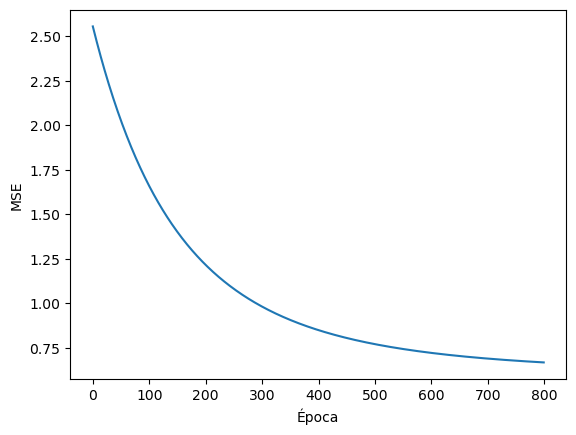

In [11]:
plt.plot(adal.mse_history); plt.xlabel("Época"); plt.ylabel("MSE"); plt.show()

In [12]:
def adaline_run_summary(X, y, n_epochs=20, eta=0.01, seed=7):
    """
    Devuelve una fila con w_init (época 1) y w_final (última época).
    Solo pesos w, sin bias.
    """
    rng = np.random.default_rng(seed)
    N, d = X.shape
    w = rng.uniform(0.0, 1.0, size=d)  # w ~ U[0,1)# 1 se inicializan los pesos w aleatorio entre 0 y 1
    b = 0.0

    w_init_first = w.copy()  # vector inicial de la 1ª época

    for _ in range(n_epochs):#se realiza el proceso de entrenamiento de acuerdo a las epocas y demas parametros 
        z = X @ w + b
        err = y - z
        grad_w = -(X.T @ err) / N
        grad_b = -err.mean()
        w -= eta * grad_w
        b -= eta * grad_b

    w_final_last = w.copy()  # vector final de la última época

    row = {"n_epochs": n_epochs}
    for j in range(d):
        row[f"w{j}_init"]  = w_init_first[j]
        row[f"w{j}_final"] = w_final_last[j]
    return row



In [13]:
# ----- 5 llamadas con distintos epochs -----
epochs_list = [20, 40, 80, 160, 320]
eta = 0.0025
seed_base = 7

rows = []
for i, ne in enumerate(epochs_list, start=1):
    row = adaline_run_summary(X_tr_std, y_tr, n_epochs=ne, eta=eta, seed=seed_base + i)
    row["call"] = f"call_{i}"
    rows.append(row)

df_summary_calls = pd.DataFrame(rows, columns=["call","n_epochs"] +
                                sum([[f"w{j}_init", f"w{j}_final"] for j in range(X_tr_std.shape[1])], []))

df_summary_calls.head()
# df_summary_calls.to_csv("adaline_resumen_w_inicial_final_por_llamada.csv", index=False)

,call,n_epochs,w0_init,w0_final,w1_init,w1_final,w2_init,w2_final,w3_init,w3_final
0,call_1,20,0.326972,0.325671,0.987277,0.912257,0.318711,0.320346,0.788549,0.697646
1,call_2,40,0.870249,0.812620,0.286817,0.218103,0.603148,0.563118,0.777534,0.660764
2,call_3,80,0.956002,0.832833,0.207682,0.195191,0.828445,0.692305,0.149282,0.053312
3,call_4,160,0.128570,0.182428,0.499278,0.400684,0.601498,0.436195,0.028689,-0.180379
4,call_5,320,0.250824,0.279570,0.946753,0.544792,0.189320,0.162624,0.179291,-0.387188


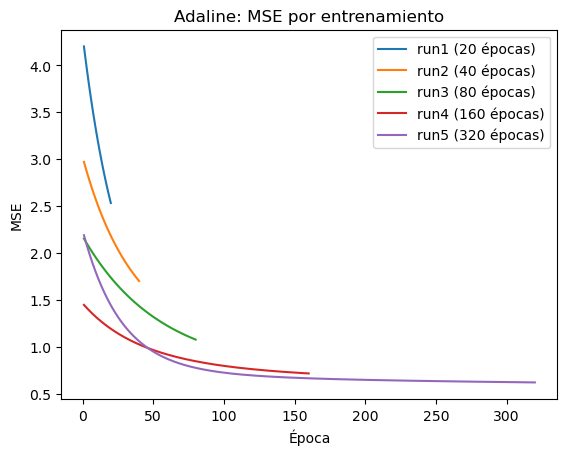

In [14]:
def adaline_run_mse(X, y, n_epochs=20, eta=0.01, seed=7):
    rng = np.random.default_rng(seed)
    N, d = X.shape
    w = rng.uniform(0.0, 1.0, size=d)# 1 se inicializan los pesos w aleatorio entre 0 y 1
    b = 0.0
    mse_hist = []

    for _ in range(n_epochs):#se realiza el proceso de entrenamiento de acuerdo a las epocas y demas parametros 
        z = X @ w + b
        err = y - z
        mse_hist.append(np.mean(err**2))     # MSE de esta época (antes de actualizar)
        grad_w = -(X.T @ err) / N
        grad_b = -err.mean()
        w -= eta * grad_w
        b -= eta * grad_b

    return mse_hist

# --- 5 entrenamientos con distintos números de épocas ---
epochs_list = [20, 40, 80, 160, 320]
eta = 0.01
seed_base = 7

histories = []
for i, ne in enumerate(epochs_list, start=1):
    mse_hist = adaline_run_mse(X_tr_std, y_tr, n_epochs=ne, eta=eta, seed=seed_base + i)
    histories.append((f"run{i} ({ne} épocas)", mse_hist))

# --- un solo plot con todas las curvas ---
plt.figure()
for label, hist in histories:
    plt.plot(range(1, len(hist)+1), hist, label=label)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Adaline: MSE por entrenamiento")
plt.legend()
plt.show()

In [15]:
# --- 3) Adaline desde cero ---
class AdalineGD:
    def __init__(self, eta=0.01, n_epochs=50, seed=7):
        self.eta=eta; self.n_epochs=n_epochs
        self.rng = np.random.default_rng(seed)
    def fit(self, X, y):
        N,d = X.shape
        self.w = self.rng.uniform(0.0,1.0,size=d)  # init U[0,1) # 1 se inicializan los pesos w aleatorio entre 0 y 1
        self.b = 0.0
        for _ in range(self.n_epochs):#se realiza el proceso de entrenamiento de acuerdo a las epocas y demas parametros 
            z = X @ self.w + self.b
            err = y - z
            grad_w = -(X.T @ err)/N
            grad_b = -err.mean()
            self.w -= self.eta*grad_w
            self.b -= self.eta*grad_b
        return self
    def predict_cont(self, X):  # score lineal
        return X @ self.w + self.b
    def predict_class(self, X):
        return np.where(self.predict_cont(X)>=0, 1.0, -1.0)

# --- 4) Entrenamientos con distintas épocas y clasificación del dataset 2 ---
epochs_list = [20, 40, 80, 160, 320]
eta = 0.0025
preds = pd.DataFrame(index=df_val.index)   # almacenará predicciones por run
scores = pd.DataFrame(index=df_val.index)  # almacenará scores lineales

for i, ne in enumerate(epochs_list, start=1):
    model = AdalineGD(eta=eta, n_epochs=ne, seed=7+i).fit(X_tr_std, y_tr)
    y2_score = model.predict_cont(X2_std)
    y2_pred  = np.where(y2_score>=0, 1.0, -1.0)
    preds[f"pred_run{i}_e{ne}"]  = y2_pred
    scores[f"score_run{i}_e{ne}"] = y2_score

# --- 5) Ensamble opcional sobre las 5 corridas ---
# voto mayoritario
preds["vote_majority"] = np.sign(preds.filter(like="pred_run").sum(axis=1)).replace(0, 1.0)
# promedio de scores -> signo
scores["avg_score"] = scores.mean(axis=1)
preds["sign_avg_score"] = np.where(scores["avg_score"]>=0, 1.0, -1.0)

# --- 6) Resultado final para dataset 2 ---
resultado = pd.concat([df_val.reset_index(drop=True), preds.reset_index(drop=True), scores[["avg_score"]].reset_index(drop=True)], axis=1)
resultado.head(20)
# resultado.to_csv("clasificacion_dataset2_varias_epocas.csv", index=False)

,sample,x1,x2,x3,x4,pred_run1_e20,pred_run2_e40,pred_run3_e80,pred_run4_e160,pred_run5_e320,vote_majority,sign_avg_score,avg_score
0,1,0.9694,0.6909,0.4334,3.4965,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.873265
1,2,0.5427,1.3832,0.6390,4.0352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.049889
2,3,0.6081,-0.9196,0.5925,0.1016,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-0.158729
3,4,-0.1618,0.4694,0.2030,3.0117,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.649056
4,5,0.1870,-0.2578,0.6124,1.7749,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-0.142822
5,6,0.4891,-0.5276,0.4378,0.6439,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.286824
6,7,0.3777,2.0149,0.7423,3.3932,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.216615
7,8,1.1498,-0.4067,0.2469,1.5866,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.215696
8,9,0.9325,1.0950,1.0359,3.3591,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.792998
9,10,0.5060,1.3317,0.9222,3.7174,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.350385
